<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/GP15_Defining_Watermass_Subtypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install py_pcha
!pip install gsw

     |████████████████████████████████| 2.4MB 5.9MB/s 


Grab the data

In [7]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr" -O GLODAPv2.2019_Pacific_Ocean.csv && rm -rf /tmp/cookies.txt

--2021-05-05 13:07:52--  https://docs.google.com/uc?export=download&confirm=kXAF&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr
Resolving docs.google.com (docs.google.com)... 64.233.189.113, 64.233.189.102, 64.233.189.100, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-b4-docs.googleusercontent.com/docs/securesc/2n0infhpgqt1blh4gjfd5hv4ut77ebvo/qc863m3s0esr41vgv2j1at73cuii2b3n/1620220050000/06203730782251856755/14365528019735745486Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download [following]
--2021-05-05 13:07:52--  https://doc-08-b4-docs.googleusercontent.com/docs/securesc/2n0infhpgqt1blh4gjfd5hv4ut77ebvo/qc863m3s0esr41vgv2j1at73cuii2b3n/1620220050000/06203730782251856755/14365528019735745486Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download
Resolving doc-08-b4-docs.googleusercontent.com (doc-08-b4-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

Read in the data frame and pick a subset of columns

In [9]:
colnames_subset = ["latitude", 'longitude', 'year', 'depth',
                   'pressure', 'temperature','salinity','oxygen',
                   'silicate', 'nitrate', 'phosphate', 'sigma0']


df = pandas.read_csv("GLODAPv2.2019_Pacific_Ocean.csv",
                     na_values = -9999)[colnames_subset]

df['NO'] = df['oxygen'] + (df['nitrate']*9.68)
df['PO'] = df['oxygen'] + (df['phosphate']*155)
df['potential_temperature'] = gsw.pt_from_t(df['salinity'],
                                df['temperature'],
                                df['pressure'],
                                df['sigma0'])
df["absolute_salinity"] = gsw.SA_from_SP(
    SP=df["salinity"], p=df["pressure"],
    lon=df["longitude"], lat=df["latitude"])
df["conservative_temperature"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                  t=df["temperature"],
                                  p=df["pressure"])

In [29]:
ARCH_ANALYSIS_FEATURES = ["conservative_temperature", "absolute_salinity",
                          "silicate", "NO", "PO"]
ALL_FEATURES_TO_AVERAGE = ARCH_ANALYSIS_FEATURES+["phosphate", "nitrate", "oxygen"]

#feature_weights = {"conservative_temperature": 56.0,
#                   "absolute_salinity": 80.0,
#                   "silicate": 3.0,
#                   "NO": 5.0,
#                   "PO": 5.0}
feature_weights = {"conservative_temperature": 5.0,
                   "absolute_salinity": 5.0,
                   "silicate": 1.0,
                   "NO": 1.0,
                   "PO": 1.0}

print("Standardizing feature values")
#Let's standardize each column by subtracting mean,
# dividing by standard deviation and multiplying by the feature weights.
# Call it a 'features' dataframe
#keep track of mean and std in order to do inverse transform
colname_to_mean = {}
colname_to_std = {} 
for colname in ARCH_ANALYSIS_FEATURES:
  vals = np.array(df[colname])
  #use nanmean and nanstd to ignore nan values for now
  mean = np.nanmean(vals)
  std = np.nanstd(vals)
  colname_to_mean[colname] = mean
  colname_to_std[colname] = std
  df['standardized_'+colname] = feature_weights[colname]*(vals-mean)/std

#Since imputation takes a while on such a large dataset, we
# will just drop rows that have missing values
print("Proportions of missing values:")
print(np.sum(np.isnan(df)) / len(df))
print("Original number of rows:", len(df))
df = df.dropna()
print("Remaining rows after dropping missing vals:",len(df))

TRANSFORM_MEANS = np.array([colname_to_mean[colname]
                           for colname in ARCH_ANALYSIS_FEATURES])
TRANSFORM_STDS = np.array([(colname_to_std[colname]/feature_weights[colname])
                           for colname in ARCH_ANALYSIS_FEATURES])


#function to map features back to original space
def map_features_back(features):
  return features*TRANSFORM_STDS[None,:] + TRANSFORM_MEANS[None,:]




Standardizing feature values
Proportions of missing values:
latitude                                 0.0
longitude                                0.0
year                                     0.0
depth                                    0.0
pressure                                 0.0
temperature                              0.0
salinity                                 0.0
oxygen                                   0.0
silicate                                 0.0
nitrate                                  0.0
phosphate                                0.0
sigma0                                   0.0
NO                                       0.0
PO                                       0.0
potential_temperature                    0.0
absolute_salinity                        0.0
conservative_temperature                 0.0
standardized_conservative_temperature    0.0
standardized_absolute_salinity           0.0
standardized_silicate                    0.0
standardized_NO                         

On water mass AAIW
Ranges: {'lat_min': -51.0, 'lat_max': -47.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig0_min': 27.01, 'sig0_max': 27.1}


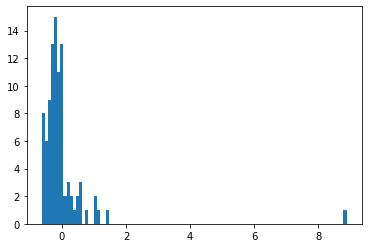

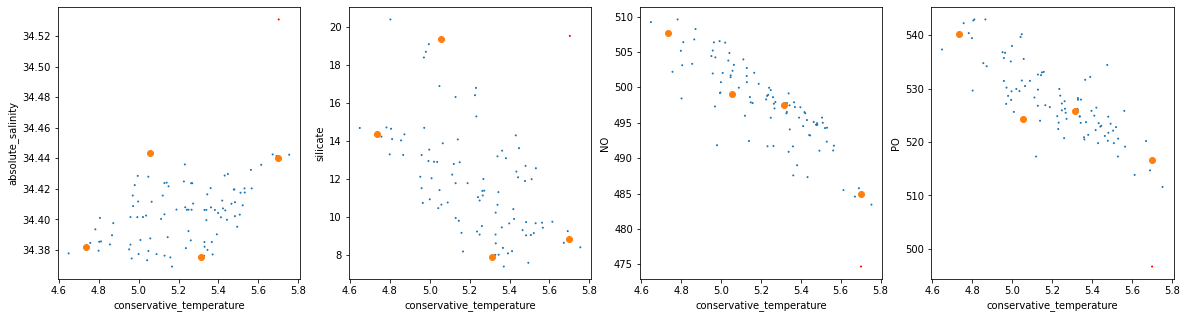

On water mass NPIW
Ranges: {'lat_min': 34.0, 'lat_max': 37.0, 'lon_min': 140.0, 'lon_max': 153.0, 'sig0_min': 26.5, 'sig0_max': 27.4}


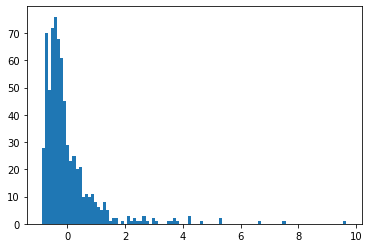

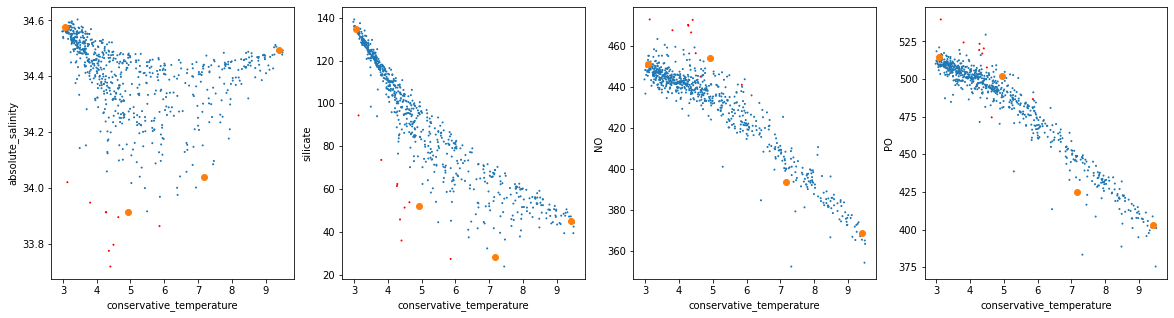

In [30]:
from py_pcha import PCHA
import scipy


def flag_outliers(features, n_neighbors=20, zscore_threshold=4):
    #Features is observations X features
    #Do a process of removing outliers; if the average distance of a point to
    # its nearest N neighbors is more than stdev number of standard deviations from
    # the mean, flag it as an outlier.
    #I tried the Extreme Studentized Deviate but it wasn't behaving very
    # predictably. I guess the distribution of neighbor distances is
    # exponential-ish rather than normal.
    pairwise_distances = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(X=features, metric="euclidean"))
    avg_dist_to_nn = np.mean(
        np.sort(pairwise_distances, axis=-1)[:,1:n_neighbors], axis=-1)
    zscore_avgdisttonn = (avg_dist_to_nn - np.mean(avg_dist_to_nn))/np.std(
                          avg_dist_to_nn)
    plt.hist(zscore_avgdisttonn, bins=100)
    plt.show()
    anomalous_indices = np.abs(zscore_avgdisttonn) > zscore_threshold
    return anomalous_indices


def run_archetype_analysis(df, num_endmembers):
    all_features = np.array([np.array(df["standardized_"+col])
                      for col in ARCH_ANALYSIS_FEATURES]).transpose((1,0))
    all_origspace_features = np.array([np.array(df[col]) for col in
                                   ALL_FEATURES_TO_AVERAGE]).transpose((1,0))

    outliers = flag_outliers(all_features)
    features = all_features[outliers==False]
    origspace_features = all_origspace_features[outliers==False]

    XC, S, C, SSE, varexpl = PCHA(X=features.T, noc=num_endmembers,
                                  verbose=False)
    archetype_features = np.array(XC).T #becomes archtetypes X features
    obs_combos_giving_archetypes = np.array(C).T #archetypes X obs combos

    origspace_archetypes = obs_combos_giving_archetypes@origspace_features

    #Make scatterplots
    fig,ax = plt.subplots(nrows=1, ncols=len(ARCH_ANALYSIS_FEATURES)-1,
                          figsize=(20,5))
    pltnum = 0
    for featureidx1 in [0]:#range(len(ALL_FEATURES_TO_AVERAGE)):
        for featureidx2 in range(featureidx1+1, len(ALL_FEATURES_TO_AVERAGE)):
            if ((ALL_FEATURES_TO_AVERAGE[featureidx1]
                 in ARCH_ANALYSIS_FEATURES) and
                (ALL_FEATURES_TO_AVERAGE[featureidx2]
                 in ARCH_ANALYSIS_FEATURES)):
                plt.sca(ax[pltnum])
                plt.scatter(all_origspace_features[:,featureidx1],
                            all_origspace_features[:,featureidx2],
                            c=[("red" if x==True else "C0") for x in outliers],
                            s=1)
                plt.scatter(origspace_archetypes[:,featureidx1],
                            origspace_archetypes[:,featureidx2],
                            color="C1")
                plt.xlabel(ALL_FEATURES_TO_AVERAGE[featureidx1])
                plt.ylabel(ALL_FEATURES_TO_AVERAGE[featureidx2]) 
                pltnum += 1
    plt.show()

    return pandas.DataFrame(dict([(colname, origspace_archetypes[:,idx])
                        for idx,colname in enumerate(ALL_FEATURES_TO_AVERAGE)]))
    

filter_conditions = {
    "AAIW": {"lat_min":-51.0, "lat_max":-47.0,
             "lon_min":-120.0, "lon_max":150.0,
             "sig0_min":27.01, "sig0_max":27.1},
    "NPIW": {"lat_min":34.0, "lat_max":37.0,
             "lon_min":140.0, "lon_max":153.0,
             "sig0_min":26.5, "sig0_max":27.4}
    
}

def filter_rows(df, lat_min, lat_max, lon_min, lon_max, sig0_min, sig0_max):
  return df[(df["latitude"] >= lat_min) &
            (df["latitude"] <= lat_max) &
            (df["longitude"] >= lon_min) &
            (df["longitude"] <= lon_max) &
            (df["sigma0"] >= sig0_min) &
            (df["sigma0"] <= sig0_max)
            ]

NUM_ARCHETYPES = 4

watermass_to_archetypes = {}

for watermass in filter_conditions:
  print("On water mass", watermass)
  print("Ranges:", filter_conditions[watermass])
  watermass_rows = filter_rows(df=df, **filter_conditions[watermass])
  watermass_archetypes = run_archetype_analysis(df=watermass_rows,
                                                num_endmembers=NUM_ARCHETYPES)
  watermass_to_archetypes[watermass] = watermass_archetypes

In [31]:
watermass_to_archetypes["AAIW"]

,conservative_temperature,absolute_salinity,silicate,NO,PO,phosphate,nitrate,oxygen
0,5.056157,34.443179,19.392000,499.044000,524.250000,1.930000,28.300000,225.100000
1,5.700008,34.439900,8.866002,485.002859,516.617167,1.636623,22.940318,262.940576
2,4.735486,34.381722,14.357563,507.737395,540.228932,1.876483,26.690429,249.374044
3,5.314469,34.375507,7.921275,497.487388,525.893676,1.609642,22.839688,276.399207


In [32]:
watermass_to_archetypes["NPIW"]

,conservative_temperature,absolute_salinity,silicate,NO,PO,phosphate,nitrate,oxygen
0,9.406264,34.493601,45.147257,368.888195,403.044310,1.707637,23.814844,138.360504
1,7.177527,34.040624,28.314147,393.699896,425.281563,1.237301,16.549581,233.499950
2,4.930687,33.914690,52.220000,453.936800,501.800000,1.980000,26.760000,194.900000
3,3.072123,34.576364,134.564138,451.076841,514.821666,3.028682,41.911242,45.376019
